In [1]:
# Find the group features that have the lowest MSE of datapoints that activate on single-features
# Specifically we're measuring the MSE(feature_mag*feature_weight, group_mag*group_weight) for 
# all datapoints that activate on a single feature
# Ideally we find multiple features that have low MSE & are subsets of groups
# Problem: We might have co-activating groups or features that should be considered together
# e.g. if two groups always fire together (ie high jaccard sim), then we should consider them together (I think)

# Download Model & SAEs

In [2]:
import os 
import sys
current_dir = "/root/GroupedSAEs/notebooks/feature_act_rec_similarity.ipynb"
sys.path.append(os.path.dirname(os.path.dirname(current_dir)))
from transformer_lens import HookedTransformer
import torch
from utils import get_sae
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# SAEs
sae_single = get_sae("gpt2_12288_gated_resid8_v2").to(device)
sae_group = get_sae("gpt2_12288_gated_grouped_resid8_v2").to(device)

# Model
model_name = "gpt2-small"
layer = 8
activation_name = f"blocks.{layer}.hook_resid_pre"
model = HookedTransformer.from_pretrained(model_name, device=device)

Loaded pretrained model gpt2-small into HookedTransformer


# Dataset

In [89]:
from datasets import load_dataset
def download_dataset(dataset_name, tokenizer, max_length=256, num_datapoints=None):
    if(num_datapoints):
        split_text = f"train[:{num_datapoints}]"
    else:
        split_text = "train"
    dataset = load_dataset(dataset_name, split=split_text).map(
        lambda x: tokenizer(x['text']),
        batched=True,
    ).filter(
        lambda x: len(x['input_ids']) > max_length
    ).map(
        lambda x: {'input_ids': x['input_ids'][:max_length]}
    )
    return dataset

dataset_name = "stas/openwebtext-10k"
max_seq_length = 40
num_datapoints = 5000
total_tokens = max_seq_length * num_datapoints
print(f"Downloading {dataset_name}")
dataset = download_dataset(dataset_name, tokenizer=model.tokenizer, max_length=max_seq_length, num_datapoints=num_datapoints)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

# Cache Feature Activations

In [85]:
#set torch grad to zero globally
torch.set_grad_enabled(False)
from torch.utils.data import DataLoader
from einops import rearrange
from tqdm import tqdm

batch_size = 128
sae = sae_single
# def get_dictionary_activations(model, dataset, cache_name, max_seq_length, autoencoder, batch_size=32):
d_model, num_features = sae_single.W_enc.data.shape
datapoints = dataset.num_rows
dictionary_activations_single = torch.zeros((datapoints*max_seq_length, num_features))
dictionary_activations_group = torch.zeros((datapoints*max_seq_length, num_features))
all_dictionary_activations = [dictionary_activations_single, dictionary_activations_group]
token_list = torch.zeros((datapoints*max_seq_length), dtype=torch.int64)

In [86]:
single_and_group_correlation = torch.zeros((num_features, num_features), dtype=torch.int32)
single_correlation = torch.zeros((num_features, num_features), dtype=torch.int32)
group_correlation = torch.zeros((num_features, num_features), dtype=torch.int32)
with torch.no_grad(), dataset.formatted_as("pt"):
    dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for batch_ind, batch in enumerate(tqdm(dl)):
        batch = batch.to(model.cfg.device)
        token_list[batch_ind*batch_size*max_seq_length:(batch_ind+1)*batch_size*max_seq_length] = rearrange(batch, "b s -> (b s)")
        activations = model.run_with_cache(batch, names_filter = activation_name)[1][activation_name]
        activations = rearrange(activations, "b s n -> (b s) n" )
        for sae_ind, sae in enumerate([sae_single, sae_group]):
            if sae.cfg.architecture == "standard":
                feature_acts = sae.encode(activations)
            else:
                feature_acts = sae.encode_gated(activations)
            all_dictionary_activations[sae_ind][batch_ind*batch_size*max_seq_length:(batch_ind+1)*batch_size*max_seq_length] = feature_acts.cpu()
            if sae_ind==0:
                first_feature_mask = (feature_acts !=0).float()
                single_correlation += torch.mm(first_feature_mask.T, first_feature_mask).int().cpu()
            else:
                second_feature_mask = (feature_acts !=0).float()
                group_correlation += torch.mm(second_feature_mask.T, second_feature_mask).int().cpu()

                # Calculate the correlation between the single and group activations
                single_and_group_correlation += torch.mm(first_feature_mask.T, second_feature_mask).int().cpu()

100%|██████████| 40/40 [01:18<00:00,  1.97s/it]


In [107]:
from einops import reduce

single_feature_frequency = single_correlation.diag() / total_tokens
single_feature_frequency.topk(10), single_feature_frequency.min(), single_feature_frequency
# Collapse group activations
collapsed_group_activations = reduce(dictionary_activations_group, 'd_point (features p) -> d_point features', 'sum', p=2)

# Initialize tensors to store results
all_feature_mse = torch.zeros((num_features, num_features // 2))
all_feature_var_exp = torch.zeros((num_features, num_features // 2))


max_num_datapoints = 500
# Iterate over features
for feature in tqdm(range(num_features)):
    if single_correlation.diag()[feature] < 10:
        continue
    if single_feature_frequency[feature] > 0.1:
        continue

    feature_nonzero_datapoint_indices = dictionary_activations_single[:, feature].nonzero()[:, 0][:max_num_datapoints]
    feature_decoder_direction = sae_single.W_dec.data[feature]
    activation_magnitudes = dictionary_activations_single[feature_nonzero_datapoint_indices, feature]
    single_feature_projections = torch.ger(activation_magnitudes.to(device), feature_decoder_direction)

    # Get group features with highest Jaccard similarity
    activation_mag_group = collapsed_group_activations[feature_nonzero_datapoint_indices]
    nz_group_features = (activation_mag_group != 0).sum(0).topk(100).indices

    # Get magnitudes and decoder directions for all group features
    first_features = nz_group_features * 2
    second_features = nz_group_features * 2 + 1

    first_feature_mags = dictionary_activations_group[feature_nonzero_datapoint_indices][:, first_features].to(device)
    second_feature_mags = dictionary_activations_group[feature_nonzero_datapoint_indices][:, second_features].to(device)

    first_feature_directions = sae_group.W_dec.data[first_features]
    second_feature_directions = sae_group.W_dec.data[second_features]

    # Calculate projections for all group features
    first_feature_projections = torch.einsum('bi,ij->bij', first_feature_mags, first_feature_directions)
    second_feature_projections = torch.einsum('bi,ij->bij', second_feature_mags, second_feature_directions)

    # Sum projections to get group projections
    group_projections = first_feature_projections + second_feature_projections

    # Calculate MSE and variance explained
    mse = torch.mean((single_feature_projections.unsqueeze(1) - group_projections) ** 2, dim=(0, -1))
    variance_explained = 1 - mse / torch.mean(single_feature_projections ** 2)

    # Store results
    all_feature_mse[feature, nz_group_features] = mse.cpu()
    all_feature_var_exp[feature, nz_group_features] = variance_explained.cpu()


100%|██████████| 12288/12288 [13:20<00:00, 15.34it/s]


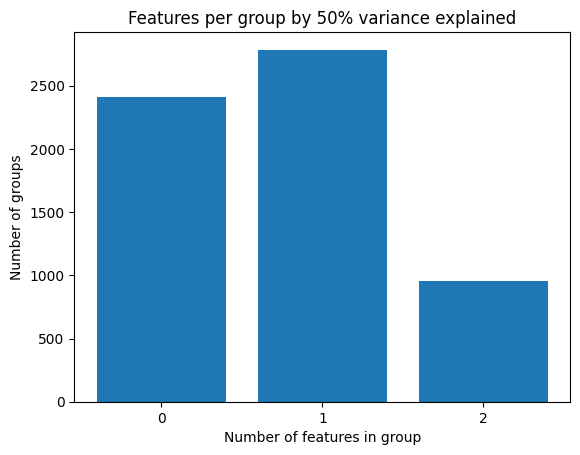

In [115]:
import numpy as np
features_per_group = (all_feature_var_exp > 0.5).sum(0).float()

# plot as bar-char w/ x-axis as number of features in group
import matplotlib.pyplot as plt
plt.bar(*np.unique(features_per_group, return_counts=True))
#x axis is 0-max integers
max = int(features_per_group.max())
plt.xticks(range(max+1))

plt.xlabel("Number of features in group")
plt.ylabel("Number of groups")
plt.title("Features per group by 50% variance explained")
plt.show()

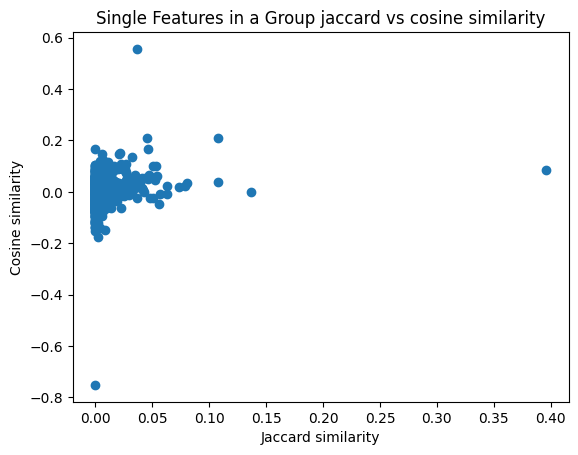

In [198]:
eps = 1e-6
var_exp_threshold = 0.5
features_per_group = (all_feature_var_exp > var_exp_threshold).sum(0).float()
group2_ind = (features_per_group == 2).nonzero()[:, 0]
bool_matrix = (all_feature_var_exp > var_exp_threshold)[:, group2_ind]
# nonzero_indices = torch.nonzero(bool_matrix, as_tuple=False)

single_jaccard_sim = (single_correlation/ (single_correlation.diag().view(-1, 1)+ eps))

s_cos_sim = torch.zeros(len(group2_ind))
s_jacc_sim = torch.zeros(len(group2_ind))
for feature_loop_ind, feature_row in tqdm(enumerate(bool_matrix.T)):
    nz_ind = feature_row.nonzero()[:, 0]
    fir_feat = sae_single.W_dec.data[nz_ind[0]]
    sec_feat = sae_single.W_dec.data[nz_ind[1]]
    s_cos_sim[feature_loop_ind] = torch.einsum('i,i->', fir_feat, sec_feat)
    # s_cos_sim = torch.einsum('ij,ij->i', fir_feat, sec_feat)
    s_jacc_sim[feature_loop_ind]  = single_jaccard_sim[nz_ind[0], nz_ind[1]]
# Plot both jaccard sim & s_cos_sim on a scatter plot
plt.scatter(s_jacc_sim.cpu(), s_cos_sim.cpu())
plt.xlabel("Jaccard similarity")
plt.ylabel("Cosine similarity")
plt.title("Within-Features in a Group jaccard vs cosine similarity")
plt.show()

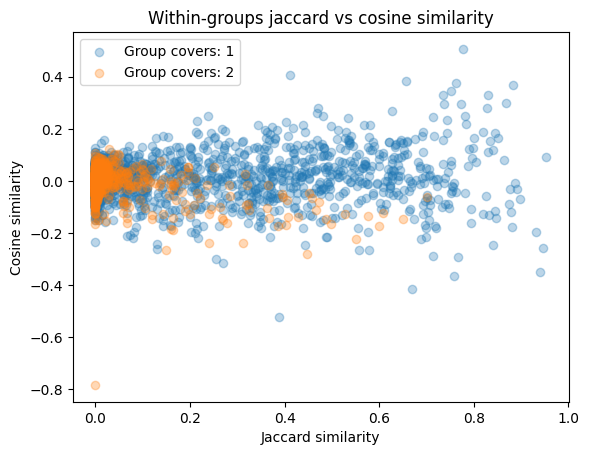

In [214]:
eps = 1e-6
var_exp_threshold = 0.5
features_per_group = (all_feature_var_exp > var_exp_threshold).sum(0).float()

for group_cover_amount in range(1,3):
    group2_ind = (features_per_group == group_cover_amount).nonzero()[:, 0]
    rows = group2_ind*2
    cols = group2_ind*2+1
    # Use advanced indexing to get the corresponding values
    group_jaccard_sim = (group_correlation/ (group_correlation.diag().view(-1, 1)+ eps))
    g_jacc_sim = group_jaccard_sim[rows, cols]

    # Now we want to do cos sim between the two features
    fir_feat = sae_group.W_dec.data[rows]
    sec_feat = sae_group.W_dec.data[cols]
    g_cos_sim = torch.einsum('ij,ij->i', fir_feat, sec_feat) 

    # Plot both jaccard sim & s_cos_sim on a scatter plot
    plt.scatter(g_jacc_sim.cpu(), g_cos_sim.cpu(), alpha=0.3, label= f"Group covers: {group_cover_amount}")
plt.xlabel("Jaccard similarity")
plt.ylabel("Cosine similarity")
plt.title("Within-groups jaccard vs cosine similarity")
plt.legend()

plt.show()

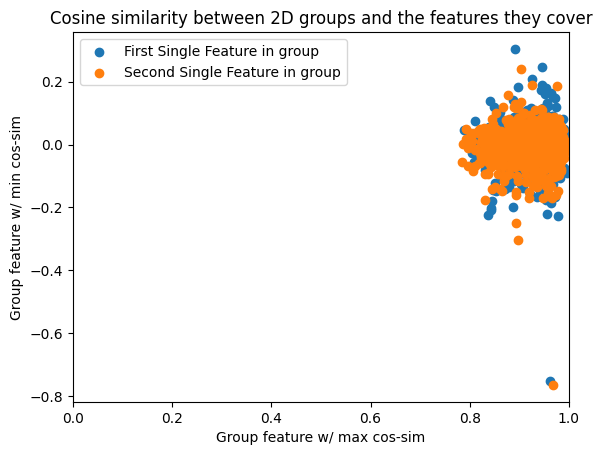

In [206]:
eps = 1e-6
var_exp_threshold = 0.5
features_per_group = (all_feature_var_exp > var_exp_threshold).sum(0).float()
group2_ind = (features_per_group == 2).nonzero()[:, 0]
bool_matrix = (all_feature_var_exp > var_exp_threshold)[:, group2_ind]
single_jaccard_sim = (single_correlation/ (single_correlation.diag().view(-1, 1)+ eps))
s_jacc_sim = single_jaccard_sim[rows, cols]


total_cos_sim = torch.zeros(4, group2_ind.shape[0])

for feature_loop_ind, feature_row in tqdm(enumerate(bool_matrix.T)):
    nz_ind = feature_row.nonzero()[:, 0]
    first_feature_ind = nz_ind[0]
    sec_feature_ind = nz_ind[1]
    fir_feat = sae_single.W_dec.data[first_feature_ind]
    sec_feat = sae_single.W_dec.data[sec_feature_ind]
    fir_group = sae_group.W_dec.data[group2_ind[feature_loop_ind]*2]
    sec_group = sae_group.W_dec.data[group2_ind[feature_loop_ind]*2+1]
    # # Find the 2x2 cos sim between (fir, sec) & (fir_group, sec_group)
    total_cos_sim[0, feature_loop_ind] = torch.einsum('i,i->', fir_feat, fir_group)
    total_cos_sim[1, feature_loop_ind] = torch.einsum('i,i->', fir_feat, sec_group)
    total_cos_sim[2, feature_loop_ind] = torch.einsum('i,i->', sec_feat, fir_group)
    total_cos_sim[3, feature_loop_ind] = torch.einsum('i,i->', sec_feat, sec_group)

max_first_feature_to_group = total_cos_sim[:2].max(0).values
min_first_feature_to_group = total_cos_sim[:2].min(0).values
max_sec_feature_to_group = total_cos_sim[2:].max(0).values
min_sec_feature_to_group = total_cos_sim[2:].min(0).values

# plot both max & min cos sim
plt.scatter(max_first_feature_to_group.cpu(), min_first_feature_to_group.cpu(), label="First Single Feature in group")
plt.scatter(max_sec_feature_to_group.cpu(), min_sec_feature_to_group.cpu(), label="Second Single Feature in group")
plt.xlabel("Group feature w/ max cos-sim")
plt.ylabel("Group feature w/ min cos-sim")
plt.title("Cosine similarity between 2D groups and the features they cover")
# set range to be 0-1
plt.xlim(0, 1)
# plt.ylim(0, 
plt.legend()

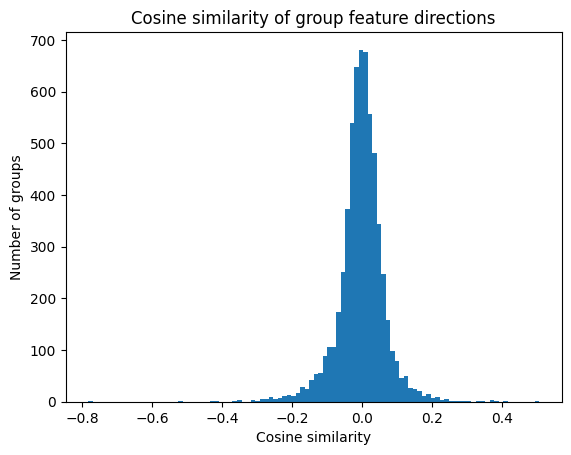

In [219]:
# Find the cos-sim of all group features directions
g_dec = sae_group.W_dec.data
# g_cos_sim = torch.einsum('ij,ij->i', g_dec[::2], g_dec[1::2])
g_cos_sim = torch.einsum('ij,ij->i', g_dec[1::2], g_dec[::2])
plt.hist(g_cos_sim.cpu(), bins=100)
plt.xlabel("Cosine similarity")
plt.ylabel("Number of groups")
plt.title("Cosine similarity of group feature directions")
plt.show()

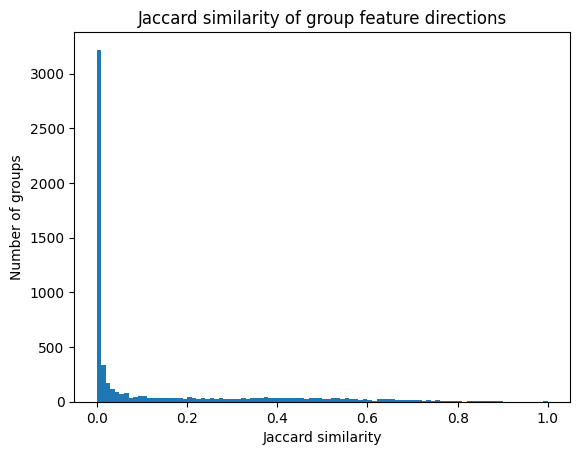

In [221]:
g_jacc_sim = (group_correlation/ (group_correlation.diag().view(-1, 1)+ eps))
num_groups = g_jacc_sim.shape[0]//2
rows = torch.arange(num_groups)*2
cols = torch.arange(num_groups)*2+1
g_jacc_sim_within_group = g_jacc_sim[rows, cols]
plt.hist(g_jacc_sim_within_group.cpu(), bins=100)
plt.xlabel("Jaccard similarity")
plt.ylabel("Number of groups")
plt.title("Jaccard similarity of group feature directions")
plt.show()

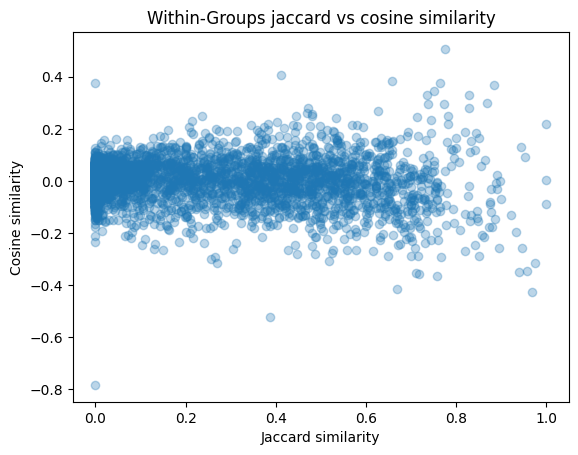

In [222]:
# plot both against each other
plt.scatter(g_jacc_sim_within_group.cpu(), g_cos_sim.cpu(), alpha=0.3)
plt.xlabel("Jaccard similarity")
plt.ylabel("Cosine similarity")
plt.title("Within-Groups jaccard vs cosine similarity")
plt.show()

In [190]:
for row in (all_feature_var_exp > var_exp_threshold)[:, group2_ind].T:
    nz_point = row.nonzero()[:, 0]
    break

In [192]:
row.shape, nz_point

(torch.Size([12288]), tensor([ 2672, 10589]))

In [186]:
fir_feat[:2].shape, sec_feat[:2].shape, fir_group[0].shape

(torch.Size([2, 768]), torch.Size([2, 768]), torch.Size([768]))

In [183]:
group2_ind.shape, (all_feature_var_exp > var_exp_threshold).shape

(torch.Size([952]), torch.Size([12288, 6144]))

In [177]:
bool_matrix.nonzero()[0], group2_ind[0]

(tensor([ 0, 68]), tensor(10))

In [133]:
nonzero_indices.shape, result.shape

(torch.Size([1904, 2]), torch.Size([1904, 2]))

In [117]:
group2_ind = (features_per_group == 2).nonzero()[:, 0]
connected_single_feature_ind = group2_ind

tensor([  10,   26,   30,   33,   36,   37,   38,   43,   45,   52,   55,   62,
          68,   76,   95,  105,  110,  125,  133,  139,  148,  152,  159,  163,
         172,  173,  194,  206,  208,  214,  234,  237,  246,  248,  278,  284,
         287,  296,  299,  303,  304,  306,  307,  309,  311,  339,  357,  358,
         372,  375,  377,  388,  390,  399,  409,  418,  426,  431,  433,  453,
         455,  471,  485,  487,  500,  539,  546,  556,  560,  568,  569,  586,
         588,  620,  630,  640,  641,  642,  652,  654,  659,  662,  664,  671,
         675,  680,  684,  685,  692,  701,  708,  710,  712,  720,  721,  733,
         740,  746,  757,  759,  765,  768,  769,  771,  775,  778,  780,  792,
         793,  805,  808,  817,  818,  822,  834,  837,  838,  841,  842,  857,
         870,  873,  874,  875,  877,  880,  885,  888,  898,  903,  908,  925,
         929,  931,  938,  939,  948,  951,  953,  959,  962,  964,  967,  977,
         984,  998, 1000, 1006, 1009, 10

In [109]:
all_feature_var_exp.sum(0).topk(20), all_feature_var_exp[:, 2940].topk(10)

(torch.return_types.topk(
 values=tensor([1.8740, 1.8536, 1.8376, 1.8200, 1.8087, 1.8068, 1.8013, 1.7986, 1.7619,
         1.7595, 1.7501, 1.7496, 1.7474, 1.7459, 1.7451, 1.7302, 1.7177, 1.7147,
         1.7093, 1.6982]),
 indices=tensor([3910, 5257,  837, 6051, 4617,  746,  455, 2204, 3820, 5244, 5957, 2172,
         6021, 5195,  733, 1190, 1407, 1108,  159,  838])),
 torch.return_types.topk(
 values=tensor([0.9361, 0.8121, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]),
 indices=tensor([2362, 1847,    8,    4,    9,    7,    3,    1,    5,    0])))

In [98]:
all_feature_var_exp.sum(0).topk(20), all_feature_var_exp[:, 2940].topk(10)

(torch.return_types.topk(
 values=tensor([1.8379, 1.8095, 1.7950, 1.7837, 1.7753, 1.7619, 1.7486, 1.7459, 1.7324,
         1.7126, 1.7043, 1.6983, 1.6982, 1.6931, 1.6857, 1.6854, 1.6701, 1.6506,
         1.6457, 1.6203]),
 indices=tensor([ 837, 3818, 1212, 5213, 1884, 3820, 2940, 5195, 1108, 1407, 1140, 1943,
         5987, 4183, 5255, 5316, 3889, 4551,  641, 3717])),
 torch.return_types.topk(
 values=tensor([0.9361, 0.8124, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]),
 indices=tensor([2362, 1847,    8,    4,    9,    7,    3,    1,    5,    0])))

In [23]:
feature = 0
feature_nonzero_datapoint_indices = dictionary_activations_single[:, feature].nonzero()[:, 0]
feature_decoder_direction = sae_single.W_dec.data[feature]

activation_magnitudes = dictionary_activations_single[feature_nonzero_datapoint_indices, feature]
feature_nonzero_datapoint_indices, activation_magnitudes

activation_mag_group = collapsed_group_activations[feature_nonzero_datapoint_indices]
# nz_group_features = (activation_mag_group.sum(0) !=0).nonzero()[:, 0]
nz_group_features = (activation_mag_group !=0).sum(0).topk(50).indices

# Slight problem: we'd like to sum over 

torch.return_types.topk(
values=tensor([92, 92, 92, 91, 88, 65, 65, 64, 60, 57, 56, 55, 54, 51, 50, 47, 46, 45,
        45, 45, 43, 43, 40, 40, 40, 37, 36, 35, 34, 33, 33, 33, 33, 32, 32, 32,
        31, 31, 31, 31, 31, 31, 30, 29, 29, 29, 29, 29, 28, 28]),
indices=tensor([ 5229,  5228,  7646,  7647,  2227,  8872,  9697,  1121, 10127,  9062,
         3631,  1120,  5720, 11484,  9696,  9786,  9787,  1694, 10447,  4593,
        10126,  8878, 10446, 11193, 11233,  9016,  8879,   551,  5415, 11232,
         5039, 12146,  3503, 10614, 10373,  3502,  1695,  6276, 11398,   983,
         3630,  5414, 12254,   512,  5529,  4628, 11520,   550,  2734,   340]))

In [30]:
feature = 0
feature_nonzero_datapoint_indices = dictionary_activations_single[:, feature].nonzero()[:, 0]
feature_decoder_direction = sae_single.W_dec.data[feature]

activation_magnitudes = dictionary_activations_single[feature_nonzero_datapoint_indices, feature]
feature_nonzero_datapoint_indices, activation_magnitudes

activation_mag_group = collapsed_group_activations[feature_nonzero_datapoint_indices]
# nz_group_features = (activation_mag_group.sum(0) !=0).nonzero()[:, 0]
nz_group_features = (activation_mag_group !=0).sum(0).topk(100).indices

# This is over the collapsed groups
# TODO: find activation of each group which is index*2 and index*2+1 
(activation_mag_group !=0).sum(0).topk(100)

torch.return_types.topk(
values=tensor([92, 92, 88, 71, 65, 64, 64, 60, 57, 55, 54, 52, 51, 50, 50, 45, 44, 43,
        42, 41, 41, 39, 38, 37, 36, 35, 35, 34, 33, 33, 33, 32, 32, 32, 32, 31,
        31, 30, 30, 30, 29, 29, 29, 27, 27, 27, 27, 26, 25, 25, 25, 25, 25, 25,
        25, 24, 24, 24, 24, 24, 24, 24, 23, 23, 23, 22, 22, 22, 22, 21, 21, 20,
        20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 19, 19, 19, 18, 18, 18, 18,
        18, 18, 18, 18, 18, 18, 17, 17, 17, 17]),
indices=tensor([3823, 2614, 1113, 4848, 4436,  560, 5063, 1815, 4531, 4893, 2860, 5742,
        4439, 5223,  847, 2296, 5596, 4508, 5616,  275, 1751, 2707, 3138, 2519,
        6073, 2314,  621,  385, 5186,  491, 5307, 5699, 4054, 1367,  170, 1408,
        6127, 3381,  256, 2764, 5757, 5760, 4015, 1033, 1306, 5296, 1716, 5362,
        5398, 5220, 1414, 4675,   59, 2759, 2481, 5284, 5315, 1311,   51, 5378,
        5345, 1848, 1605, 4677, 3104,  326, 4742, 1941, 4296,  854, 1419,  300,
        4037,    5, 4118, 4520

In [56]:
single_feature_projections = torch.ger(activation_magnitudes.to(device),feature_decoder_direction)
group_mse = torch.zeros((len(nz_group_features)))
group_ve = torch.zeros((len(nz_group_features)))
for group_loop_ind, group_feat in enumerate(nz_group_features):
    first_feature = group_feat*2
    second_feature = group_feat*2+1
    first_feature_mag = dictionary_activations_group[feature_nonzero_datapoint_indices, first_feature]
    second_feature_mag = dictionary_activations_group[feature_nonzero_datapoint_indices, second_feature]
    first_feature_decoder_direction = sae_group.W_dec.data[first_feature]
    second_feature_decoder_direction = sae_group.W_dec.data[second_feature]
    first_feature_projections = torch.ger(first_feature_mag.to(device),first_feature_decoder_direction)
    second_feature_projections = torch.ger(second_feature_mag.to(device),second_feature_decoder_direction)
    group_projections = first_feature_projections + second_feature_projections
    mse = torch.mean((single_feature_projections - group_projections)**2)
    variance_explained = 1 - mse/torch.mean(single_feature_projections**2)
    group_mse[group_loop_ind] = mse
    group_ve[group_loop_ind] = variance_explained

In [67]:
val, ind = all_feature_var_exp.sum(0).topk(20)
all_feature_var_exp[:, ind].topk(10)

torch.return_types.topk(
values=tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]),
indices=tensor([[15, 11, 12,  ..., 18, 10, 16],
        [15, 11, 12,  ..., 18, 10, 16],
        [15, 11, 12,  ..., 18, 10, 16],
        ...,
        [15, 11, 12,  ..., 18, 10, 16],
        [15, 11, 12,  ..., 18, 10, 16],
        [15, 11, 12,  ..., 18, 10, 16]]))

In [69]:
all_feature_var_exp.sum(0).topk(20), all_feature_var_exp[:, 837].topk(10)

(torch.return_types.topk(
 values=tensor([1.8385, 1.8161, 1.7806, 1.7437, 1.7298, 1.6978, 1.6186, 1.6027, 1.5832,
         1.5786, 1.5457, 1.5399, 1.5068, 1.5058, 1.4742, 1.4714, 1.4641, 1.4594,
         1.4070, 1.4063]),
 indices=tensor([ 837, 3818, 3984, 1407, 3271, 3782,  133, 5255, 5640, 3111, 3382, 2905,
          588, 2849, 3555, 2746, 3162, 4392, 1896, 3517])),
 torch.return_types.topk(
 values=tensor([0.9429, 0.8955, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]),
 indices=tensor([1570, 2761,    8,    4,    9,    7,    3,    1,    5,    0])))

In [79]:
# cos_sim = (single_feature_projections/ torch.norm(single_feature_projections, dim=-1, keepdim=True) @ group_projections.T / (torch.norm(single_feature_projections) * torch.norm(group_projections)) # TODO: norm of right direction?4
eps = 1e-8
cos_sim = (single_feature_projections/ (single_feature_projections.norm(dim=-1, keepdim=True)+eps)) @ (group_projections/ (group_projections.norm(dim=-1, keepdim=True)+eps)).T

In [83]:
cos_sim[3]

tensor([-0.0556, -0.0556,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0556,
         0.0000,  0.0000,  0.0000,  0.0000, -0.0556, -0.0556,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0120,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        -0.0556,  0.0000,  0.0000,  0.0000,  0.0000, -0.0556,  0.0000,  0.0000,
         0.0000], device='cuda:0')

In [75]:
(single_feature_projections/ single_feature_projections.norm(dim=-1, keepdim=True)), group_projections.T.shape

(tensor([[ 2.2564e-02,  3.4096e-02, -1.5106e-05,  ...,  5.5702e-02,
          -7.9622e-02,  3.2540e-02],
         [ 2.2564e-02,  3.4096e-02, -1.5106e-05,  ...,  5.5702e-02,
          -7.9622e-02,  3.2540e-02],
         [ 2.2564e-02,  3.4096e-02, -1.5106e-05,  ...,  5.5702e-02,
          -7.9622e-02,  3.2540e-02],
         ...,
         [ 2.2564e-02,  3.4096e-02, -1.5106e-05,  ...,  5.5702e-02,
          -7.9622e-02,  3.2540e-02],
         [ 2.2564e-02,  3.4096e-02, -1.5106e-05,  ...,  5.5702e-02,
          -7.9622e-02,  3.2540e-02],
         [ 2.2564e-02,  3.4096e-02, -1.5106e-05,  ...,  5.5702e-02,
          -7.9622e-02,  3.2540e-02]], device='cuda:0'),
 torch.Size([768, 49]))

In [37]:
feature_decoder_direction

tensor([ 1.6216e-02, -2.1840e-02, -1.7377e-02, -2.5888e-02, -1.7223e-02,
        -3.5605e-02,  7.0932e-02,  3.2053e-02,  1.3125e-02, -2.1245e-03,
        -2.6442e-02,  2.8824e-02, -3.7868e-02, -6.3022e-02,  5.8935e-02,
        -1.8358e-02,  1.7854e-02, -1.9896e-02,  1.2044e-02,  3.6743e-02,
        -7.6102e-03, -1.1701e-01,  5.1271e-02, -1.0541e-01,  1.1568e-02,
        -4.4505e-02,  2.1560e-02,  4.5608e-02, -4.4369e-02, -7.0746e-03,
        -2.0542e-02,  7.4906e-03, -2.4336e-02,  3.5385e-02, -2.5444e-02,
         2.0758e-02, -4.4299e-02,  9.0215e-03, -1.1604e-02, -4.5212e-02,
        -1.7518e-02, -7.1846e-03, -3.5854e-02, -1.4172e-02,  2.9790e-02,
        -3.7508e-02,  3.1754e-02,  2.5918e-02, -1.7112e-02,  2.4165e-02,
        -1.0628e-02,  1.5652e-02, -2.3694e-02, -9.9563e-04,  2.5389e-02,
        -6.9215e-02, -3.7875e-03,  1.0567e-02,  2.2085e-03,  1.3947e-02,
        -2.9126e-02, -1.9012e-02,  1.0881e-01, -1.5689e-02,  7.5367e-03,
        -1.4398e-02, -4.4473e-02,  1.9385e-03, -5.5

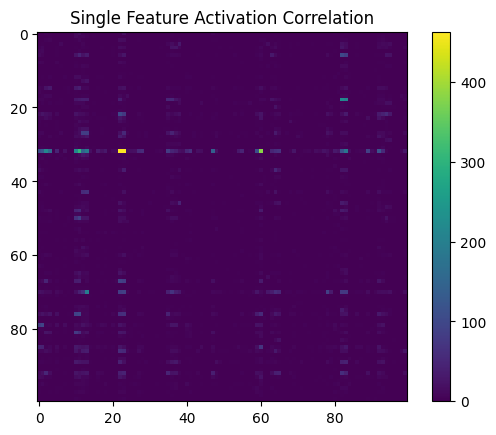

In [174]:
# plot single and group correlation
from matplotlib import pyplot as plt
plt.imshow(single_and_group_correlation[:100, :100])
plt.title("Single-to-Group Feature Activation Correlation")
plt.colorbar()
plt.show()

In [198]:
# Get frequency of time single features & group features fire together, by total number of single features (single as subset of group)
subset_similarity_single_to_group = (single_and_group_correlation/ single_correlation.diag().view(-1, 1))

In [202]:
jaccard_threshold = 0.9
(subset_similarity_single_to_group > jaccard_threshold).sum(0).topk(50)

torch.return_types.topk(
values=tensor([12178, 12160, 12054,  9938,  2699,   296,   253,    88,    79,    74,
           47,    34,    32,    31,    26,    26,    24,    24,    24,    23,
           22,    22,    19,    19,    18,    17,    17,    17,    17,    16,
           16,    15,    15,    15,    15,    15,    14,    14,    14,    14,
           13,    13,    13,    12,    12,    12,    12,    12,    12,    12]),
indices=tensor([ 5228,  5229,  7646,  7647,  2227,  9062, 11484, 11485,  3960,  1243,
         3961, 11172, 11173,  1242,  6353, 10756,   965,  8801,  6231,  6230,
         8800,  6365,  5529, 10720,  5353, 10614,  7459,  7458,  5528,  8879,
         1161, 10721,   964,  5352,  3661,  9063, 10615,  6352,  8708,  1661,
        12249,  9435, 10799,  9277,  1722,  5778,  3892,  8141,  3893,   540]))

In [212]:
(subset_similarity_single_to_group > jaccard_threshold)[:, 540].float().topk(12).indices, 

tensor([ 6033,  2812,  5045,  7769,  1575,  8417,  3895, 10722,  1709, 11524,
         2491,   575])

In [215]:
high_single_features = (subset_similarity_single_to_group > jaccard_threshold)[:, 540].float().topk(12).indices
for feat_ind, h_feature in enumerate(high_single_features):
    h_feature = high_single_features[feat_ind]
    # index features that aren't feat_ind
    other_features = high_single_features[high_single_features != h_feature]
    total_nz_feature_activations = single_correlation.diag()[h_feature]
    correlations = single_correlation[h_feature, other_features] / total_nz_feature_activations
    print(f"Feature {h_feature} has {total_nz_feature_activations} activations")
    print(f"correlations: {correlations}")

Feature 6033 has 817 activations
correlations: tensor([0.5373, 0.9963, 1.0000, 0.3158, 0.3476, 1.0000, 1.0000, 0.7956, 0.8678,
        1.0000, 0.2644])
Feature 2812 has 533 activations
correlations: tensor([0.8236, 0.9981, 1.0000, 0.2495, 0.4447, 1.0000, 1.0000, 0.6961, 0.7861,
        1.0000, 0.2270])
Feature 5045 has 997 activations
correlations: tensor([0.8164, 0.5336, 1.0000, 0.3410, 0.3801, 1.0000, 1.0000, 0.7653, 0.8746,
        1.0000, 0.3350])
Feature 7769 has 1000 activations
correlations: tensor([0.8170, 0.5330, 0.9970, 0.3410, 0.3790, 1.0000, 1.0000, 0.7660, 0.8750,
        1.0000, 0.3340])
Feature 1575 has 341 activations
correlations: tensor([0.7566, 0.3900, 0.9971, 1.0000, 0.2258, 1.0000, 1.0000, 0.8152, 0.9355,
        1.0000, 0.4839])
Feature 8417 has 379 activations
correlations: tensor([0.7493, 0.6253, 1.0000, 1.0000, 0.2032, 1.0000, 1.0000, 0.7203, 0.8549,
        1.0000, 0.3166])
Feature 3895 has 1000 activations
correlations: tensor([0.8170, 0.5330, 0.9970, 1.0000,

In [193]:
single_and_group_correlation.shape, single_correlation.diag().shape

(torch.Size([12288, 12288]), torch.Size([12288]))

In [194]:
single_correlation.diag().view(-1, 1)

torch.Size([12288, 1])

In [187]:
single_and_group_correlation[0].topk(10), single_correlation.diag()

(torch.return_types.topk(
 values=tensor([92, 92, 92, 91, 88, 65, 65, 64, 60, 57], dtype=torch.int32),
 indices=tensor([ 5228,  7646,  5229,  7647,  2227,  8872,  9697,  1121, 10127,  9062])),
 tensor([  92,  145,  151,  ..., 2589,   37, 1259], dtype=torch.int32))

In [155]:
import numpy as np

def pseudo_correlation(matrix1, matrix2):
    # Ensure both matrices are numpy arrays
    matrix1 = np.asarray(matrix1)
    matrix2 = np.asarray(matrix2)

    # Get the nonzero boolean masks
    mask1 = matrix1 != 0
    mask2 = matrix2 != 0

    # Calculate the pseudo-correlation matrix
    result = np.dot(mask1.T, mask2)

    return result

# Example usage:
batch, feature = 100, 50
matrix1 = np.random.randn(batch, feature)
matrix2 = np.random.randn(batch, feature)

correlation_matrix = pseudo_correlation(matrix1, matrix2)
correlation_matrix.shape

(50, 50)

In [153]:
torch.mm(feature_acts.T, feature_acts)[0].topk(10)

torch.return_types.topk(
values=tensor([67.8065, 49.4089, 48.8099, 42.2077, 40.3590, 33.3455, 31.1990, 30.2649,
        28.6652, 28.1365], device='cuda:0'),
indices=tensor([ 7646,  2386,  5228, 11484,  5428, 11472,   452,  7647, 11485,  7177],
       device='cuda:0'))

In [146]:
((feature_acts*feature_acts) == 0).int().sum(0).shape, feature_acts[:3].count_nonzero()

(torch.Size([12288]), tensor(264, device='cuda:0'))

In [37]:
(dictionary_activations_single[:10000] != 0).sum(-1).float().mean(), dictionary_activations_single.shape

(tensor(91.6806), torch.Size([40000, 12288]))

In [38]:
nz_single_list = (dictionary_activations_single !=0)
nz_group_list = (dictionary_activations_group !=0)

In [112]:
# Find high frequency group features
nz_group_list = nz_group_list.to(device)

feature_freq_group = nz_group_list.sum(0).float() / nz_group_list.shape[0]
feature_freq_single = nz_single_list.sum(0).float() / nz_single_list.shape[0]
most_freq_features= feature_freq_group.topk(50)
num_dead_features = (feature_freq_group < 1e-5).sum()
print(f"Number of dead features: {num_dead_features}")
print(f"most_freq_features: {most_freq_features}")
feature_group_threshold = feature_freq_group.quantile(0.90).cpu()
high_freq_group_features = (feature_freq_group > feature_group_threshold).nonzero()[:, 0].cpu()

Number of dead features: 120
most_freq_features: torch.return_types.topk(
values=tensor([1.0000, 0.9967, 0.9750, 0.9643, 0.8338, 0.6667, 0.5121, 0.4090, 0.3663,
        0.3330, 0.3275, 0.3049, 0.2891, 0.2619, 0.2354, 0.2301, 0.2130, 0.2040,
        0.2004, 0.1972, 0.1887, 0.1819, 0.1693, 0.1689, 0.1653, 0.1644, 0.1591,
        0.1591, 0.1541, 0.1448, 0.1411, 0.1336, 0.1310, 0.1292, 0.1227, 0.1217,
        0.1212, 0.1208, 0.1202, 0.1192, 0.1156, 0.1154, 0.1146, 0.1133, 0.1092,
        0.1092, 0.1078, 0.1068, 0.1061, 0.1055], device='cuda:0'),
indices=tensor([ 5228,  7646,  5229,  7647,  2227,  9062, 11484,  1243,  1242, 10756,
         8879,  5529, 11485,  8878, 10757,  9435,  1694,   600,  2067,  1695,
         9063,  8592,  3632,  6353,  3633,  5528,  6277,  6276,  9818,  6702,
         6703,   512,  7480, 10614,  2734,  3150, 12038,   983,   118,  2066,
          513,  2735,  1090,  5027,  1950,  8708,  8593, 11508,  5840,  6615],
       device='cuda:0'))


In [113]:
nz_group_list[:, high_freq_group_features] = False

In [114]:
k = 10
nz_group_list[:, high_freq_group_features] = False
minimum_num_activation_threshold = 10
subset_similarity_values = torch.zeros(num_features, k)
subset_similarity_indices = torch.zeros(num_features, k, dtype=torch.int64)
for nz_single_feature_ind in tqdm(range(nz_single_list.shape[-1])):
    nz_row = nz_single_list[:, nz_single_feature_ind].to(device)
    total_nz = nz_row.sum()
    if total_nz < minimum_num_activation_threshold:
        continue
    matches = nz_row*nz_group_list.T
    subset_similarity_values[nz_single_feature_ind], subset_similarity_indices[nz_single_feature_ind]= (matches/ total_nz).sum(-1).topk(10)

  0%|          | 0/12288 [00:00<?, ?it/s]

100%|██████████| 12288/12288 [09:43<00:00, 21.05it/s]


In [ ]:
# Now let's find a group that does indeed have high jaccard similarity w/ many features
# Ideally these features are mostly mutually exclusive
# We can also just check the MSE between the top-100 jaccard sim groups & their features
# Need to account for correlated groups & correlated features
# NOTE: I might be quite inneficient here.
# We should be able to check how many features/group. If there's just 1 or 2, that's bad.

In [115]:
subset_similarity_values[:4], subset_similarity_indices[:4]

(tensor([[0.7065, 0.6957, 0.5978, 0.4891, 0.3152, 0.3152, 0.2935, 0.2609, 0.2391,
          0.2391],
         [0.8345, 0.5379, 0.3793, 0.3517, 0.3241, 0.2690, 0.2552, 0.2276, 0.2276,
          0.2138],
         [0.7086, 0.3642, 0.2715, 0.2185, 0.2119, 0.2119, 0.1854, 0.1788, 0.1523,
          0.1457],
         [0.4189, 0.3243, 0.2500, 0.1779, 0.1374, 0.1351, 0.1306, 0.1239, 0.1149,
          0.1104]]),
 tensor([[ 8872,  1121,  1120,  4593, 11520,   550,  2613,  2622,  9484, 11515],
         [12104, 12105,  4583,  3828,  9847,  3829,  9593,  4998,  4999,   227],
         [ 9623,  7838, 12153,  7167,  7166, 12199, 11820, 10526, 12198,  8839],
         [ 3866,  3345,  1349, 12022,  7966,  9107, 10251,  3262, 11746,  9106]]))

In [129]:
jaccard_threshold = 0.9
# Count all unique groups amount
groups_activated = subset_similarity_indices[(subset_similarity_values > jaccard_threshold)]
from collections import Counter
group_counter = Counter(groups_activated.flatten().cpu().numpy())

# Find the groups that have the highest number of features
group_counter.most_common(10)

[(11172, 32),
 (11173, 29),
 (6231, 23),
 (6230, 23),
 (964, 13),
 (9150, 6),
 (5870, 6),
 (6779, 5),
 (5871, 5),
 (3658, 5)]

In [134]:
top_group = [11172, 11173]
top_features = subset_similarity_indices[top_group]
top_features

tensor([[ 6535, 10700, 10701,  5282,   433,  2291,  9308, 10075,   676,  9082],
        [ 9091,   156,  9795,  3563,  1996,  4074,  9090,   992,  5905,  7407]])

In [91]:
# Find high frequency group features
feature_freq_group = nz_group_list.sum(0).float() / nz_group_list.shape[0]
feature_freq_single = nz_single_list.sum(0).float() / nz_single_list.shape[0]
most_freq_features= feature_freq_group.topk(50)
num_dead_features = (feature_freq_group < 1e-5).sum()
print(f"Number of dead features: {num_dead_features}")
print(f"most_freq_features: {most_freq_features}")
feature_group_threshold = feature_freq_group.quantile(0.90).cpu()
high_freq_group_features = (feature_freq_group > feature_group_threshold).nonzero()[:, 0].cpu()

Number of dead features: 120
most_freq_features: torch.return_types.topk(
values=tensor([1.0000, 0.9967, 0.9750, 0.9643, 0.8338, 0.6667, 0.5121, 0.4090, 0.3663,
        0.3330, 0.3275, 0.3049, 0.2891, 0.2619, 0.2354, 0.2301, 0.2130, 0.2040,
        0.2004, 0.1972, 0.1887, 0.1819, 0.1693, 0.1689, 0.1653, 0.1644, 0.1591,
        0.1591, 0.1541, 0.1448, 0.1411, 0.1336, 0.1310, 0.1292, 0.1227, 0.1217,
        0.1212, 0.1208, 0.1202, 0.1192, 0.1156, 0.1154, 0.1146, 0.1133, 0.1092,
        0.1092, 0.1078, 0.1068, 0.1061, 0.1055], device='cuda:0'),
indices=tensor([ 5228,  7646,  5229,  7647,  2227,  9062, 11484,  1243,  1242, 10756,
         8879,  5529, 11485,  8878, 10757,  9435,  1694,   600,  2067,  1695,
         9063,  8592,  3632,  6353,  3633,  5528,  6277,  6276,  9818,  6702,
         6703,   512,  7480, 10614,  2734,  3150, 12038,   983,   118,  2066,
          513,  2735,  1090,  5027,  1950,  8708,  8593, 11508,  5840,  6615],
       device='cuda:0'))


In [108]:
feature_group_threshold = feature_freq_group.quantile(0.90).cpu()
high_freq_group_features = (feature_freq_group > feature_group_threshold).nonzero()[:, 0].cpu()

tensor([   10,    11,    12,  ..., 12252, 12253, 12254])

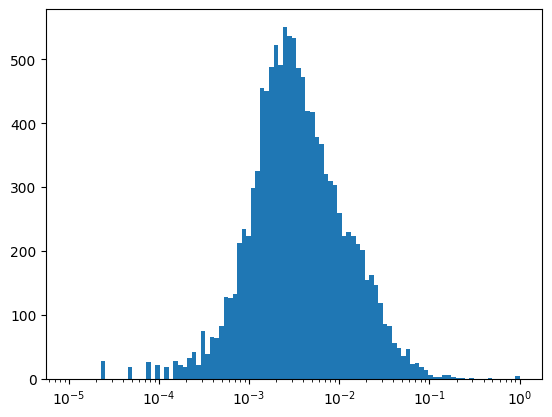

In [94]:
# plot feature_freq_group as hist
import matplotlib.pyplot as plt
import numpy as np

plt.hist(feature_freq_single.cpu().numpy(), bins=np.logspace(-5, 0, 100))
# log x-axis
plt.xscale('log')
# set x-scale units to log 10-7 to 1
# plt.xticks([1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])

plt.show()

In [76]:
nz_group_list.shape

torch.Size([40000, 12288])

In [67]:
matches.count_nonzero(-1)

tensor([ 8, 10,  1,  ...,  0,  0,  0])

In [46]:
matches.shape, nz_row.shape, nz_group_list.T.shape

(torch.Size([12288, 40000]), torch.Size([40000]), torch.Size([12288, 40000]))

In [47]:
(matches/ total_nz).sum(-1).topk(10)

torch.return_types.topk(
values=tensor([92, 92, 92, 91, 88, 65, 65, 64, 60, 57]),
indices=tensor([ 5228,  7646,  5229,  7647,  2227,  8872,  9697,  1121, 10127,  9062]))

In [50]:
(matches/ total_nz).sum(-1).topk(10)

torch.return_types.topk(
values=tensor([1.0000, 1.0000, 1.0000, 0.9891, 0.9565, 0.7065, 0.7065, 0.6957, 0.6522,
        0.6196]),
indices=tensor([ 5229,  5228,  7646,  7647,  2227,  9697,  8872,  1121, 10127,  9062]))

In [55]:
subset_similarity_values[1], subset_similarity_indices[0]

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([ 5229,  5228,  7646,  7647,  2227,  9697,  8872,  1121, 10127,  9062]))